# Forecasting Time Series

## 1. Análisis exploratorio de la serie temporal

In [192]:
ruta_excel <- "Datos.xlsx"
data <- readxl::read_excel(ruta_excel, sheet = 1)

In [193]:
head(data)

mes,pernoctacions
<dttm>,<dbl>
2024-04-01,4476.1
2024-03-01,3692.9
2024-02-01,2706.5
2024-01-01,2276.2
2023-12-01,2524.0
2023-11-01,2694.6


In [194]:
data <- data[rev(rownames(data)), ]
head(data)

mes,pernoctacions
<dttm>,<dbl>
1999-01-01,922.3
1999-02-01,1108.1
1999-03-01,1362.5
1999-04-01,2391.2
1999-05-01,3446.3
1999-06-01,4081.2


In [195]:
str(data)

tibble [304 x 2] (S3: tbl_df/tbl/data.frame)
 $ mes          : POSIXct[1:304], format: "1999-01-01" "1999-02-01" ...
 $ pernoctacions: num [1:304] 922 1108 1362 2391 3446 ...


In [196]:
data$mes <- as.Date(data$mes)

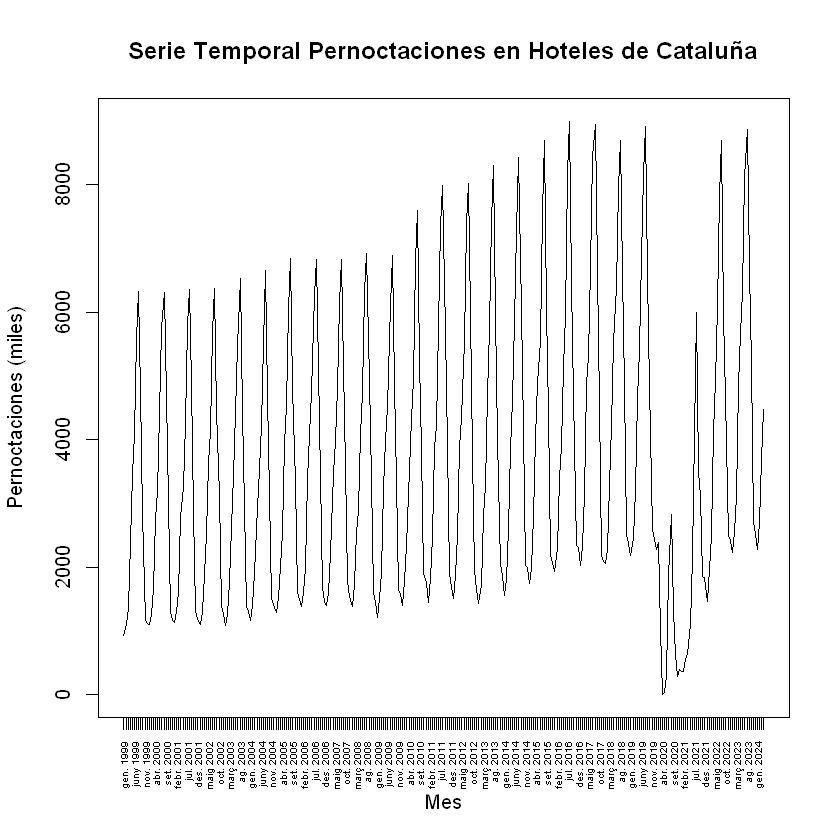

In [197]:
plot(data$mes, data$pernoctacions, type = "l", xaxt = "n", xlab = "Mes", ylab = "Pernoctaciones (miles)", main = "Serie Temporal Pernoctaciones en Hoteles de Cataluña")
axis.Date(1, at = seq(min(data$mes), max(data$mes), by = "months"), format = "%b %Y", las = 2, cex.axis = 0.5)

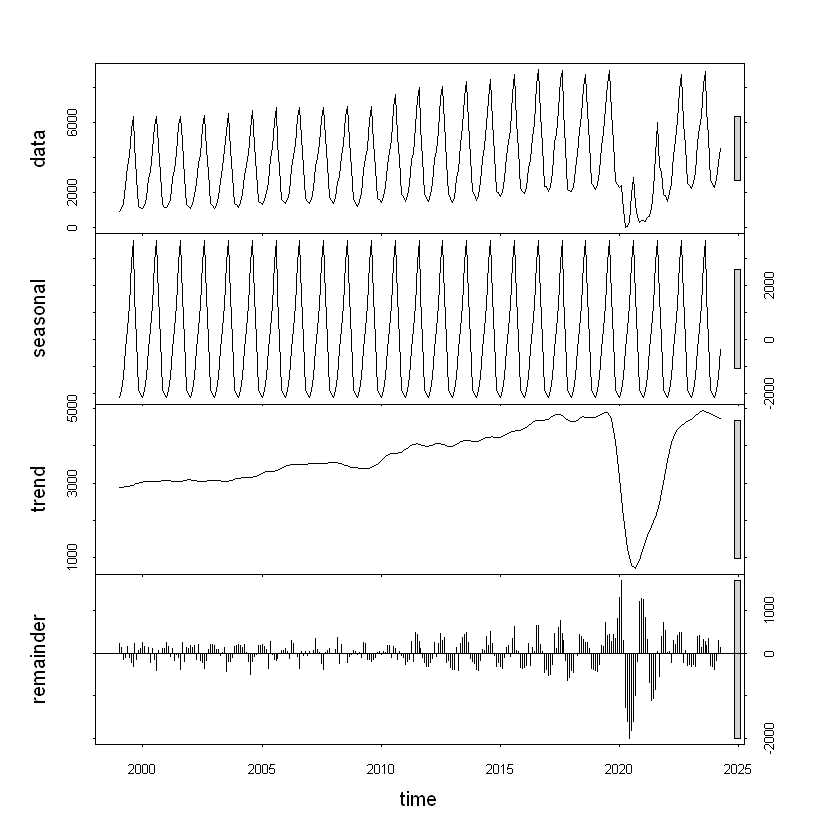

In [198]:
library(lubridate)

ts_data <- ts(data$pernoctacions, start = c(year(min(data$mes)), month(min(data$mes))), frequency = 12)

decomposed <- stl(ts_data, "periodic")

plot(decomposed)

SERIE TIPO 4: con tendencia y componente estacional

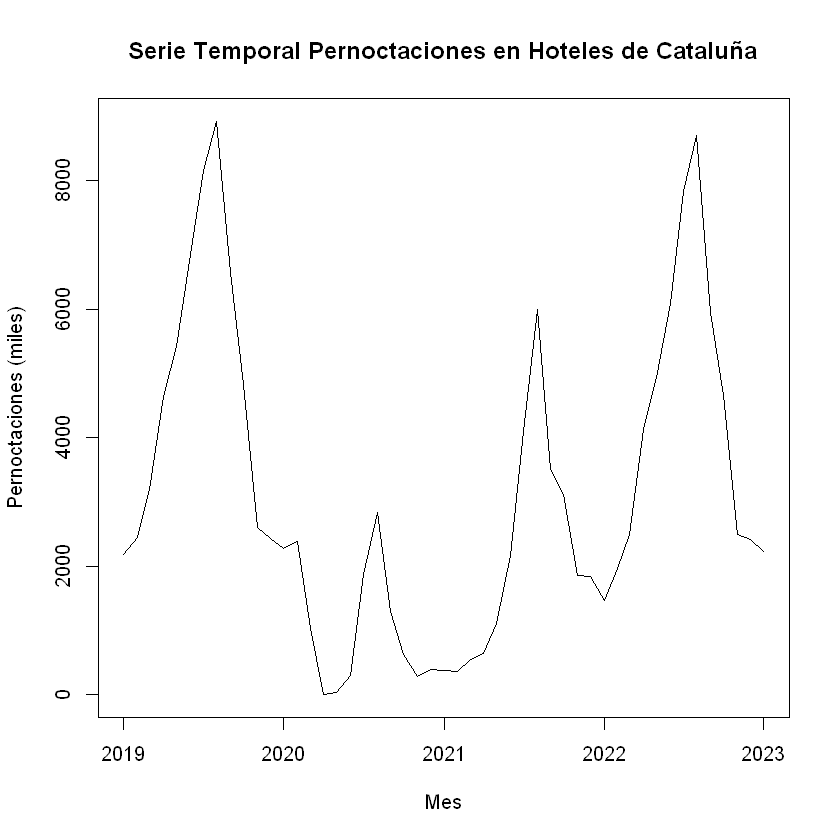

In [199]:
data_subset <- subset(data, mes >= ymd("2019-01-01") & mes <= ymd("2023-01-01"))
plot(data_subset$mes, data_subset$pernoctacions, type = "l", xlab = "Mes", ylab = "Pernoctaciones (miles)", main = "Serie Temporal Pernoctaciones en Hoteles de Cataluña")

In [200]:
data_filtered <- subset(data, year(mes) < 2020 | year(mes) > 2022)

In [201]:
nrow(data_filtered)

[1] 268

In [202]:
install.packages('openxlsx')

Warning message:
"package 'openxlsx' is in use and will not be installed"


In [203]:
library(openxlsx)

ruta_excel <- "data_filtered.xlsx"

write.xlsx(data_filtered, ruta_excel)

## 2. Método de Alisado de Holt-Winters

In [204]:
head(data_filtered)

mes,pernoctacions
<date>,<dbl>
1999-01-01,922.3
1999-02-01,1108.1
1999-03-01,1362.5
1999-04-01,2391.2
1999-05-01,3446.3
1999-06-01,4081.2


In [205]:
periodo_muestral <- data_filtered[1:216, ]
periodo_extra_muestral <- data_filtered[217:nrow(data_filtered), ]

tail(periodo_muestral)

mes,pernoctacions
<date>,<dbl>
2016-07-01,8171.5
2016-08-01,8994.2
2016-09-01,6450.2
2016-10-01,4685.3
2016-11-01,2338.2
2016-12-01,2312.3


In [206]:
fecha <- periodo_muestral$mes
valor <- periodo_muestral$pernoctacions
serie_temporal <- ts(valor, start = c(year(min(fecha)), month(min(fecha))), frequency = 12)

In [207]:
modelo_hw <- HoltWinters(serie_temporal)

In [208]:
modelo_hw

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = serie_temporal)

Smoothing parameters:
 alpha: 0.1218829
 beta : 0
 gamma: 0.6743921

Coefficients:
           [,1]
a    4790.84385
b      10.22598
s1  -2649.87338
s2  -2356.57843
s3  -1389.37712
s4   -641.87052
s5    452.27912
s6   1267.87103
s7   3328.69096
s8   4212.09917
s9   1647.35450
s10  -120.66742
s11 -2408.17162
s12 -2469.46608

## 3. Método Estocrástico: ARIMA

Warning message in adf.test(serie_dif_est):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  serie_dif_est
Dickey-Fuller = -8.0712, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



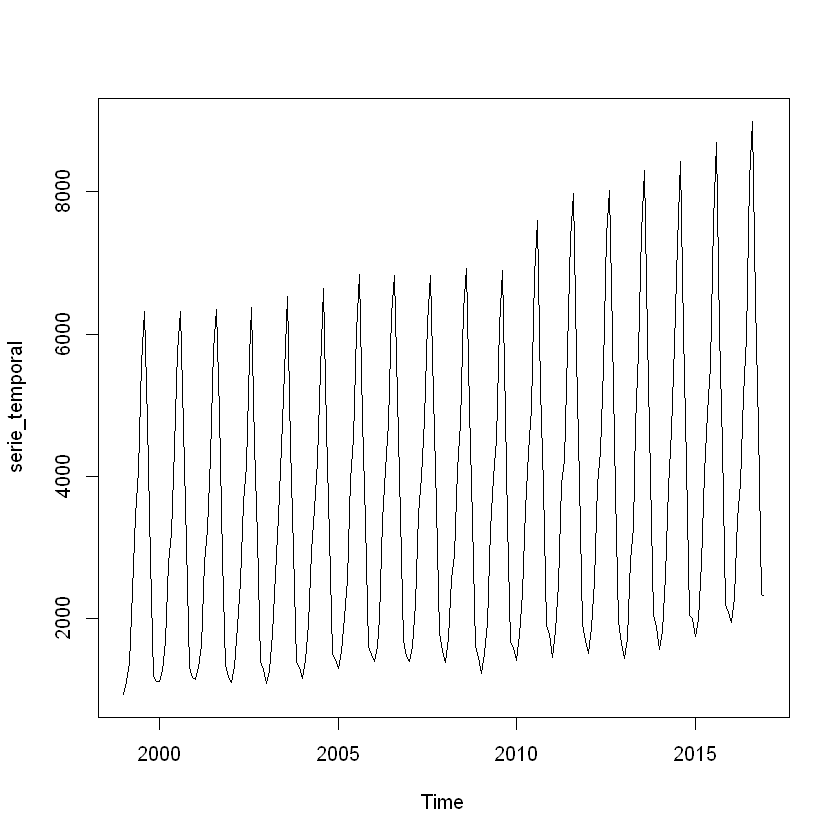

In [209]:
plot(serie_temporal)
adf_test_dif_est <- adf.test(serie_dif_est)
print(adf_test_dif_est)

Comprovamos que las series resultantes y que usaremos para el modelo son estacionarias con el test de Dickev-Fuller.

A partir de aquí decidimos crear el modelo ARIMA.

In [210]:
library(forecast)

In [211]:
fit <- auto.arima(serie_temporal)
summary(fit)
result <- forecast(fit, h = 84)
print(result$mean)

Series: serie_temporal 
ARIMA(1,0,2)(2,1,1)[12] with drift 

Coefficients:
         ar1      ma1     ma2     sar1     sar2    sma1   drift
      0.7351  -0.5278  0.2270  -0.9475  -0.5099  0.5994  8.0688
s.e.  0.0970   0.1131  0.0812   0.0964   0.0648  0.1004  1.8428

sigma^2 = 34084:  log likelihood = -1354.12
AIC=2724.23   AICc=2724.97   BIC=2750.78

Training set error measures:
                      ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.05198504 176.3118 129.9768 -0.6423937 4.210451 0.6998679
                     ACF1
Training set -0.001538191

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2017 2046.573 2359.432 3247.075 4214.288 5105.656 6021.874 8000.140 8959.432
2018 2107.204 2393.679 3329.175 4238.653 5256.842 5991.619 8102.390 9082.395
2019 2232.958 2562.244 3561.291 4294.276 5366.927 6222.400 8330.942 9221.645
2020 2320.851 2623.023 3537.455 4467.094 5423.479 6257.110 8300.201 9264.952
2021 2411.392 2717.425 3679.622 4512.930 5551.702 6344.487 8450.726 9390.853
2022 2518.728 2834.927 3795.012 4619.320 5639.316 6481.937 8561.718 9487.420
2023 2608.801 2913.399 3851.131 4733.083 5728.862 6545.092 8617.743 9569.667
          Sep      Oct      Nov      Dec
2017 6481.681 4667.371 2381.847 2356.230
2018 6480.087 4789.897 2508.228 2433.473
2019 6703.545 4920.933 2604.203 2575.850
2020 6730.577 4972.244 2686.767 2639.504
2021 6828.963 5094.750 2797.540 2744.533
2022 6959.898 5190.453 2888.423 2850.501
2023 7023.612 5275.249 2983.768 2934.483


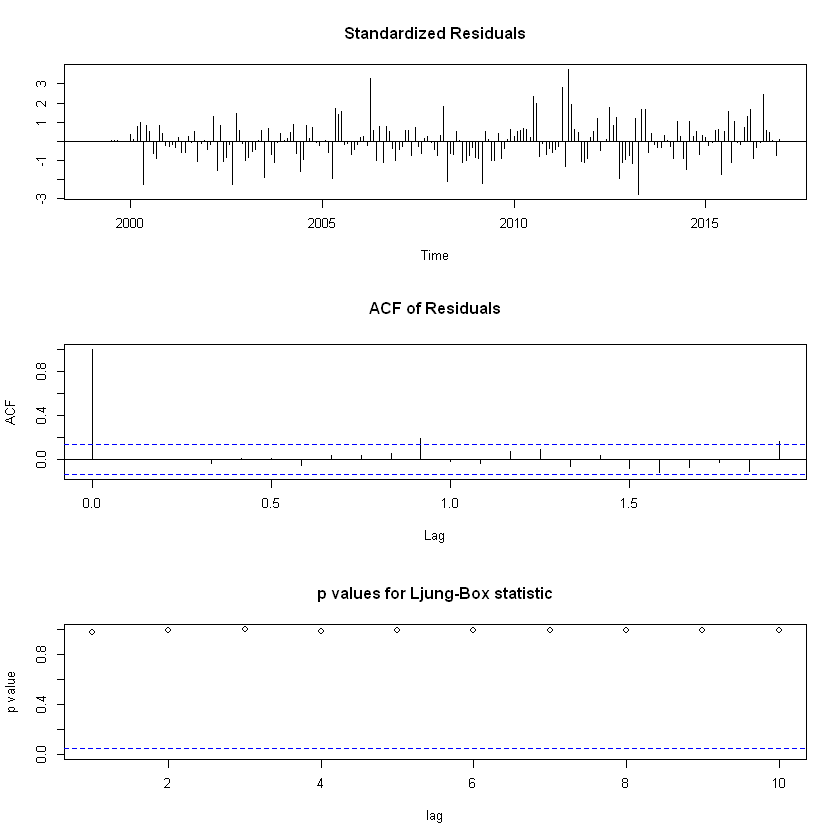

In [212]:
tsdiag(fit)

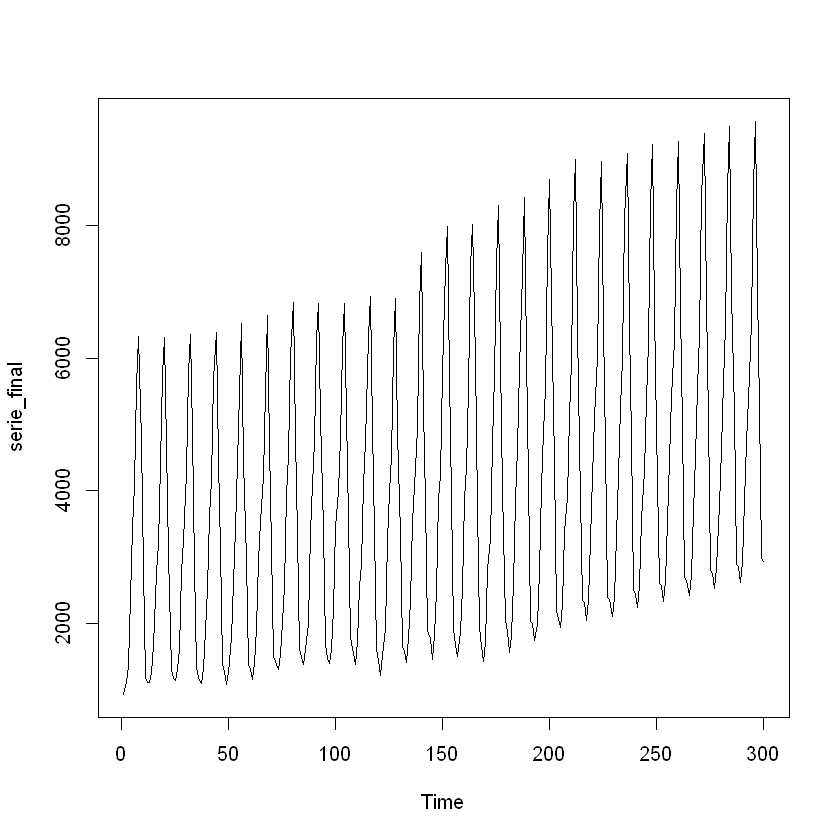

In [213]:
serie_final <- c(serie_temporal, result$mean)
plot.ts(serie_final)

In [214]:
serie_final

[1]  922.300 1108.100 1362.500 2391.200 3446.300 4081.200 5585.700 6322.900
  [9] 4754.100 2824.700 1181.100 1112.600 1104.600 1263.000 1669.500 2770.100
 [17] 3188.500 4403.500 5750.100 6315.600 4678.700 3035.600 1304.100 1160.700
 [25] 1139.700 1302.200 1609.500 2778.200 3248.000 4267.100 5787.600 6350.800
 [33] 4879.100 2858.100 1328.000 1185.100 1094.700 1312.100 1885.800 2521.700
 [41] 3631.500 4148.300 5689.800 6379.100 4444.900 3134.300 1390.000 1273.100
 [49] 1079.800 1260.500 1782.900 2616.600 3431.400 4419.700 5472.500 6523.400
 [57] 4432.600 2955.000 1377.300 1301.900 1155.800 1397.600 1915.500 2941.700
 [65] 3530.000 4217.900 5506.100 6647.500 4674.600 3147.600 1504.800 1420.400
 [73] 1296.700 1525.500 2009.300 2549.800 3945.000 4532.700 6039.400 6839.400
 [81] 4795.500 3349.400 1599.500 1494.300 1383.700 1600.000 1994.900 3377.400
 [89] 4086.700 4736.800 6271.900 6821.100 5101.000 3424.100 1679.000 1461.400
 [97] 1393.400 1603.800 2212.000 3462.300 3991.500 4800.200 6154.900 6828.200
[105] 5127.200 3577.300 1782.900 1547.200 1379.800 1730.400 2547.400 2887.600
[113] 4085.400 4743.600 6329.000 6920.800 4938.800 3378.300 1596.400 1444.800
[121] 1214.400 1506.800 1919.500 3251.200 3984.900 4515.900 6107.400 6896.100
[129] 4858.700 3359.700 1656.100 1584.100 1404.800 1776.200 2343.800 3526.700
[137] 4330.100 4946.400 6818.000 7592.000 5237.200 3849.200 1896.600 1763.300
[145] 1452.600 1829.700 2474.600 3881.700 4221.300 5781.800 7348.900 7983.100
[153] 5703.500 3908.900 1908.300 1679.300 1501.300 1863.300 2517.000 3880.700
[161] 4341.500 5533.400 7385.400 8020.200 5975.600 3767.000 1946.900 1644.200
[169] 1429.400 1710.700 2808.000 3273.700 4711.700 5750.800 7434.000 8296.300
[177] 5963.600 3998.500 2048.800 1869.900 1558.100 1811.200 2600.000 3845.500
[185] 4635.400 5855.800 7276.100 8422.000 6035.700 4157.100 2033.000 1995.200
[193] 1737.100 1978.000 2787.900 4039.600 4892.100 5543.300 7577.300 8697.000
[201] 6033.700 4421.800 2197.700 2076.700 1937.700 2285.900 3387.400 3901.400
[209] 5135.400 5951.300 8171.500 8994.200 6450.200 4685.300 2338.200 2312.300
[217] 2046.573 2359.432 3247.075 4214.288 5105.656 6021.874 8000.140 8959.432
[225] 6481.681 4667.371 2381.847 2356.230 2107.204 2393.679 3329.175 4238.653
[233] 5256.842 5991.619 8102.390 9082.395 6480.087 4789.897 2508.228 2433.473
[241] 2232.958 2562.244 3561.291 4294.276 5366.927 6222.400 8330.942 9221.645
[249] 6703.545 4920.933 2604.203 2575.850 2320.851 2623.023 3537.455 4467.094
[257] 5423.479 6257.110 8300.201 9264.952 6730.577 4972.244 2686.767 2639.504
[265] 2411.392 2717.425 3679.622 4512.930 5551.702 6344.487 8450.726 9390.853
[273] 6828.963 5094.750 2797.540 2744.533 2518.728 2834.927 3795.012 4619.320
[281] 5639.316 6481.937 8561.718 9487.420 6959.898 5190.453 2888.423 2850.501
[289] 2608.801 2913.399 3851.131 4733.083 5728.862 6545.092 8617.743 9569.667
[297] 7023.612 5275.249 2983.768 2934.483

In [226]:
library(openxlsx)

# Dividir la cadena de datos en un vector numérico
data_final <- as.numeric(unlist(strsplit(as.character(serie_final), " ")))

# Crear un data frame
data_final <- data.frame(datos = data_final)

# Escribir el data frame en un archivo Excel
write.xlsx(data_final, "serie_final.xlsx", rowNames = FALSE)

Filtramos la serie para coger solo información sobre los últimos años y ver si mejora la precisión:

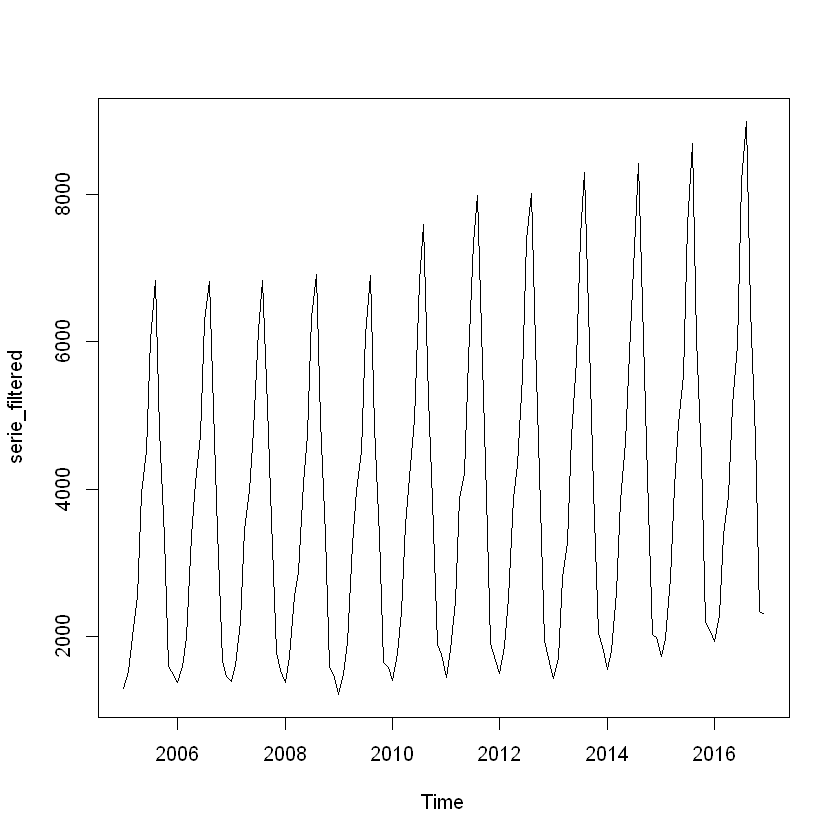

In [216]:
serie_filtered <- window(serie_temporal, start=c(2005, 1), end=c(2016, 12))
plot(serie_filtered)

In [217]:
fit_2 <- auto.arima(serie_filtered)
summary(fit)
result_2 <- forecast(fit_2, h = 84)
print(result_2$mean)

Series: serie_temporal 
ARIMA(1,0,2)(2,1,1)[12] with drift 

Coefficients:
         ar1      ma1     ma2     sar1     sar2    sma1   drift
      0.7351  -0.5278  0.2270  -0.9475  -0.5099  0.5994  8.0688
s.e.  0.0970   0.1131  0.0812   0.0964   0.0648  0.1004  1.8428

sigma^2 = 34084:  log likelihood = -1354.12
AIC=2724.23   AICc=2724.97   BIC=2750.78

Training set error measures:
                      ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.05198504 176.3118 129.9768 -0.6423937 4.210451 0.6998679
                     ACF1
Training set -0.001538191

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2017 2005.523 2254.155 3201.203 4001.058 5102.916 6006.087 8059.475 8975.412
2018 2101.817 2371.009 3310.716 4150.831 5219.173 6117.615 8130.924 9051.571
2019 2211.646 2485.973 3424.487 4269.044 5330.304 6226.185 8232.366 9153.361
2020 2320.928 2596.029 3534.193 4379.165 5439.146 6334.499 8339.568 9260.644
2021 2429.593 2704.790 3642.874 4487.880 5547.652 6442.919 8447.826 9368.923
2022 2538.099 2813.307 3751.375 4596.384 5656.124 6551.379 8556.262 9477.363
2023 2646.575 2921.784 3859.850 4704.859 5764.594 6659.847 8664.727 9585.829
          Sep      Oct      Nov      Dec
2017 6479.742 4702.603 2456.729 2373.071
2018 6560.708 4784.662 2559.543 2473.221
2019 6663.511 4888.285 2666.966 2580.791
2020 6771.021 4996.001 2775.316 2689.197
2021 6879.343 5104.363 2883.776 2797.666
2022 6987.791 5212.817 2992.245 2906.137
2023 7096.258 5321.285 3100.715 3014.607


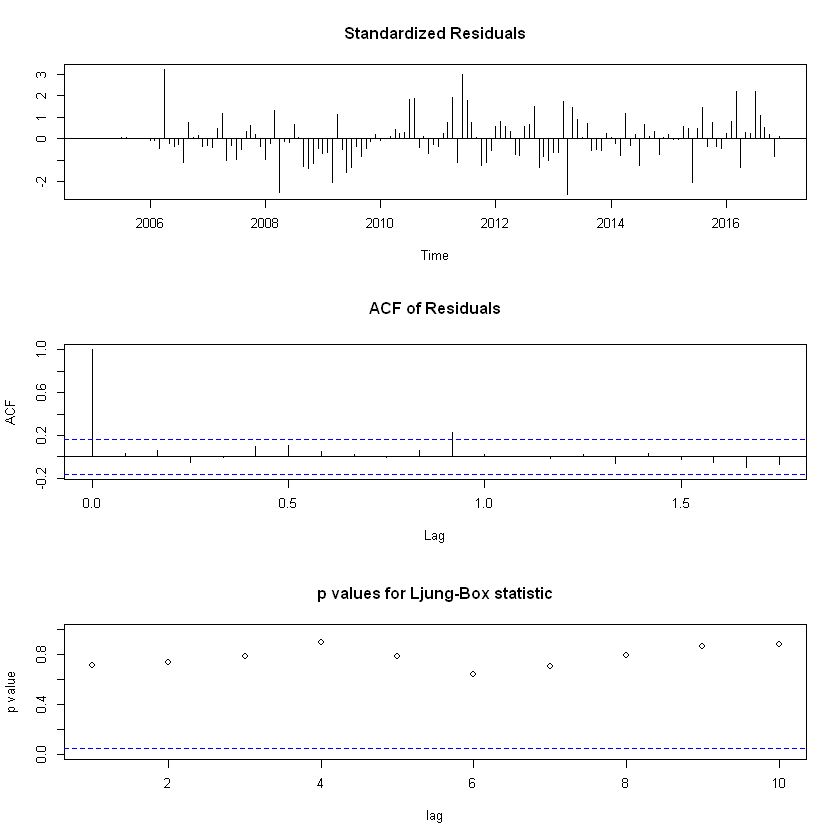

In [218]:
tsdiag(fit_2)

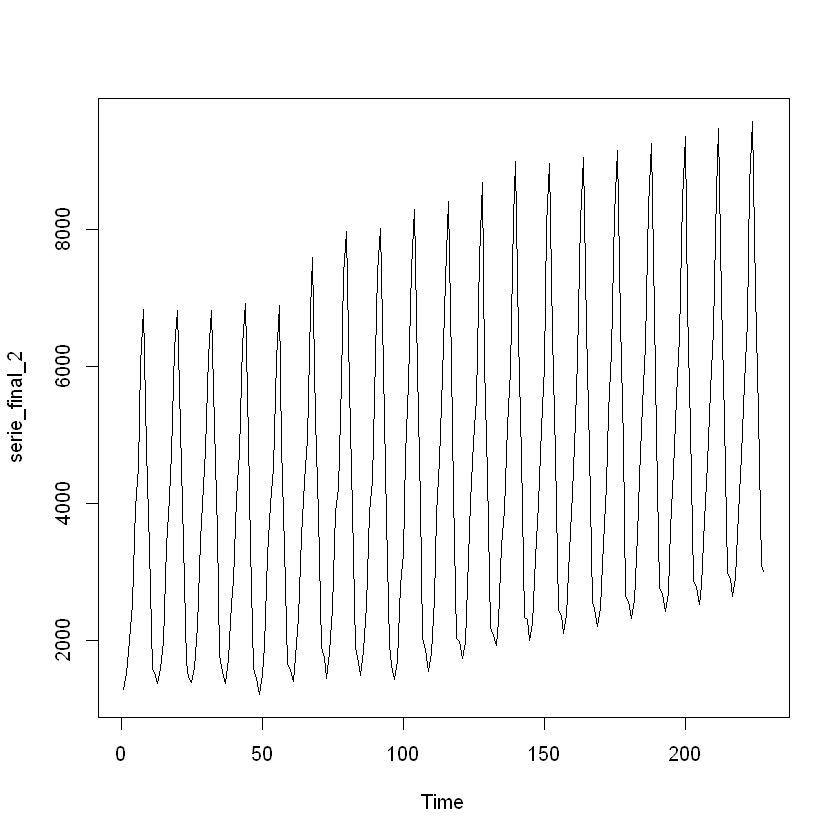

In [219]:
serie_final_2 <- c(serie_filtered, result_2$mean)
plot.ts(serie_final_2)

In [221]:
serie_final_2

[1] 1296.700 1525.500 2009.300 2549.800 3945.000 4532.700 6039.400 6839.400
  [9] 4795.500 3349.400 1599.500 1494.300 1383.700 1600.000 1994.900 3377.400
 [17] 4086.700 4736.800 6271.900 6821.100 5101.000 3424.100 1679.000 1461.400
 [25] 1393.400 1603.800 2212.000 3462.300 3991.500 4800.200 6154.900 6828.200
 [33] 5127.200 3577.300 1782.900 1547.200 1379.800 1730.400 2547.400 2887.600
 [41] 4085.400 4743.600 6329.000 6920.800 4938.800 3378.300 1596.400 1444.800
 [49] 1214.400 1506.800 1919.500 3251.200 3984.900 4515.900 6107.400 6896.100
 [57] 4858.700 3359.700 1656.100 1584.100 1404.800 1776.200 2343.800 3526.700
 [65] 4330.100 4946.400 6818.000 7592.000 5237.200 3849.200 1896.600 1763.300
 [73] 1452.600 1829.700 2474.600 3881.700 4221.300 5781.800 7348.900 7983.100
 [81] 5703.500 3908.900 1908.300 1679.300 1501.300 1863.300 2517.000 3880.700
 [89] 4341.500 5533.400 7385.400 8020.200 5975.600 3767.000 1946.900 1644.200
 [97] 1429.400 1710.700 2808.000 3273.700 4711.700 5750.800 7434.000 8296.300
[105] 5963.600 3998.500 2048.800 1869.900 1558.100 1811.200 2600.000 3845.500
[113] 4635.400 5855.800 7276.100 8422.000 6035.700 4157.100 2033.000 1995.200
[121] 1737.100 1978.000 2787.900 4039.600 4892.100 5543.300 7577.300 8697.000
[129] 6033.700 4421.800 2197.700 2076.700 1937.700 2285.900 3387.400 3901.400
[137] 5135.400 5951.300 8171.500 8994.200 6450.200 4685.300 2338.200 2312.300
[145] 2005.523 2254.155 3201.203 4001.058 5102.916 6006.087 8059.475 8975.412
[153] 6479.742 4702.603 2456.729 2373.071 2101.817 2371.009 3310.716 4150.831
[161] 5219.173 6117.615 8130.924 9051.571 6560.708 4784.662 2559.543 2473.221
[169] 2211.646 2485.973 3424.487 4269.044 5330.304 6226.185 8232.366 9153.361
[177] 6663.511 4888.285 2666.966 2580.791 2320.928 2596.029 3534.193 4379.165
[185] 5439.146 6334.499 8339.568 9260.644 6771.021 4996.001 2775.316 2689.197
[193] 2429.593 2704.790 3642.874 4487.880 5547.652 6442.919 8447.826 9368.923
[201] 6879.343 5104.363 2883.776 2797.666 2538.099 2813.307 3751.375 4596.384
[209] 5656.124 6551.379 8556.262 9477.363 6987.791 5212.817 2992.245 2906.137
[217] 2646.575 2921.784 3859.850 4704.859 5764.594 6659.847 8664.727 9585.829
[225] 7096.258 5321.285 3100.715 3014.607

In [227]:
library(openxlsx)

# Dividir la cadena de datos en un vector numérico
data_final_2 <- as.numeric(unlist(strsplit(as.character(serie_final_2), " ")))

# Crear un data frame
data_final_2 <- data.frame(datos = data_final_2)

# Escribir el data frame en un archivo Excel
write.xlsx(data_final_2, "serie_final_2.xlsx", rowNames = FALSE)

Resultados finales:

Con todos los datos de la serie:
- Datos entrenamiento: serie_temporal
- Resultados: result$mean
- Total: serie final 

Con solo datos desde 2005:
- Datos entrenamiento: serie_filtered
- Resultados: result_2$mean
- Total: serie final 2